### Import Libraries

In [1]:
import tensorflow as tf
import keras.backend as K
from tensorflow import keras
physical_devices = tf.config.experimental.list_physical_devices('GPU')
if len(physical_devices) > 0:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout, RandomCrop, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.utils.vis_utils import plot_model
import matplotlib.pyplot as plt
import pydot
import graphviz
import numpy as np

### Model

In [2]:
# Load VGG16 pre-traied model on ImageNet for Transfer Learning
base_model = keras.applications.VGG16(
    weights='imagenet',
    input_shape=(256, 256, 3),
    include_top=False)

### Transfer Learning

In [3]:
# Freeze base model
base_model.trainable = False

In [4]:
# Create inputs with correct shape
inputs = keras.Input(shape=(256,256,3))

x = base_model(inputs, training=False)

# Add pooling layer or flatten layer
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.BatchNormalization()(x)

x = keras.layers.Dense(512, activation ='relu')(x)
x = keras.layers.BatchNormalization()(x)

x = keras.layers.Dense(256, activation ='relu')(x)
x = keras.layers.BatchNormalization()(x)

x = keras.layers.Dense(128, activation ='relu')(x)
x = keras.layers.BatchNormalization()(x)

x = keras.layers.Dense(64, activation ='relu')(x)
x = keras.layers.BatchNormalization()(x)

x = keras.layers.Flatten()(x)

# Add final dense layer
outputs = keras.layers.Dense(20, activation = 'softmax')(x)

# Combine inputs and outputs to create model
model = keras.Model(inputs, outputs)

In [5]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 vgg16 (Functional)          (None, 8, 8, 512)         14714688  
                                                                 
 global_average_pooling2d (G  (None, 512)              0         
 lobalAveragePooling2D)                                          
                                                                 
 batch_normalization (BatchN  (None, 512)              2048      
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 512)               262656    
                                                                 
 batch_normalization_1 (Batc  (None, 512)              2048  

### Focal loss Function

In [12]:
def categorical_focal_loss(gamma=2.0, alpha=0.25):
    """
    Implementation of Focal Loss from the paper in multiclass classification
    Formula:
        loss = -alpha*((1-p)^gamma)*log(p)
    Parameters:
        alpha -- the same as wighting factor in balanced cross entropy
        gamma -- focusing parameter for modulating factor (1-p)
    Default value:
        gamma -- 2.0 as mentioned in the paper
        alpha -- 0.25 as mentioned in the paper
    """
    def focal_loss(y_true, y_pred):
        # Define epsilon so that the backpropagation will not result in NaN
        # for 0 divisor case
        epsilon = K.epsilon()
        # Add the epsilon to prediction value
        #y_pred = y_pred + epsilon
        # Clip the prediction value
        y_pred = K.clip(y_pred, epsilon, 1.0-epsilon)
        # Calculate cross entropy
        cross_entropy = -y_true*K.log(y_pred)
        # Calculate weight that consists of  modulating factor and weighting factor
        weight = alpha * y_true * K.pow((1-y_pred), gamma)
        # Calculate focal loss
        loss = weight * cross_entropy
        # Sum the losses in mini_batch
        loss = K.sum(loss, axis=1)
        return loss
    
    return focal_loss

In [13]:
model.compile(loss = [categorical_focal_loss()] , metrics = ['categorical_accuracy'], optimizer=keras.optimizers.Adam(learning_rate = 0.001))

In [8]:
# Create a data generator
datagen_train = ImageDataGenerator(
    samplewise_center=True,  # set each sample mean to 0
    rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
    zoom_range=0.1,  # Randomly zoom image
    width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
    height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
    horizontal_flip=True,  # randomly flip images
    vertical_flip=False,
)  # we don't expect Bo to be upside-down so we will not flip vertically

# No need to augment validation data
datagen_valid = ImageDataGenerator(samplewise_center=True)

In [9]:
# load and iterate training dataset
train_it = datagen_train.flow_from_directory(
    'Dermnet/train/',
    target_size=(256, 256),
    color_mode="rgb",
    class_mode="categorical",
    batch_size= 32
)
# load and iterate validation dataset
valid_it = datagen_valid.flow_from_directory(
    'Dermnet/test/',
    target_size=(256, 256),
    color_mode="rgb",
    class_mode="categorical",
    batch_size= 32
)

Found 13246 images belonging to 20 classes.
Found 3320 images belonging to 20 classes.


In [10]:
# Custom Stop function to stop when the validation loss stop decreasing (check every 10 epochs & the change at min 0.001)
custom_early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_loss', 
    patience=5, 
    min_delta=0.001, 
    mode='min'
)

In [14]:
history = model.fit(train_it,
          validation_data=valid_it,
          steps_per_epoch=train_it.samples/train_it.batch_size,
          validation_steps=valid_it.samples/valid_it.batch_size,
          epochs=20,
          callbacks = [custom_early_stopping]
         )

Epoch 1/20
413/413 [==============================] - 254s 601ms/step - loss: 0.5266 - categorical_accuracy: 0.2765 - val_loss: 0.4865 - val_categorical_accuracy: 0.3407
Epoch 2/20
413/413 [==============================] - 252s 608ms/step - loss: 0.4266 - categorical_accuracy: 0.3581 - val_loss: 0.4411 - val_categorical_accuracy: 0.3678
Epoch 3/20
413/413 [==============================] - 252s 609ms/step - loss: 0.3901 - categorical_accuracy: 0.3940 - val_loss: 0.4283 - val_categorical_accuracy: 0.3798
Epoch 4/20
413/413 [==============================] - 258s 622ms/step - loss: 0.3647 - categorical_accuracy: 0.4202 - val_loss: 0.4046 - val_categorical_accuracy: 0.4048
Epoch 5/20
413/413 [==============================] - 260s 628ms/step - loss: 0.3426 - categorical_accuracy: 0.4438 - val_loss: 0.3901 - val_categorical_accuracy: 0.4105
Epoch 6/20
413/413 [==============================] - 253s 610ms/step - loss: 0.3202 - categorical_accuracy: 0.4727 - val_loss: 0.3908 - val_categoric

KeyboardInterrupt: 

In [22]:
model.save('VGG16-FocalLoss.h5')

In [ ]:
model = keras.models.load_model('VGG16-FocalLoss.h5')

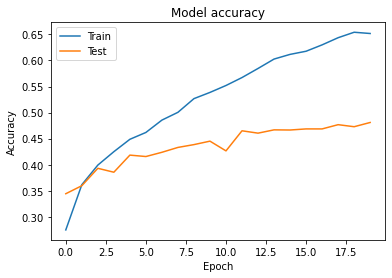

In [34]:
plt.plot(history.history['categorical_accuracy']) #sparse_categorical_accuracy
plt.plot(history.history['val_categorical_accuracy']) #val_sparse_categorical_accuracy
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

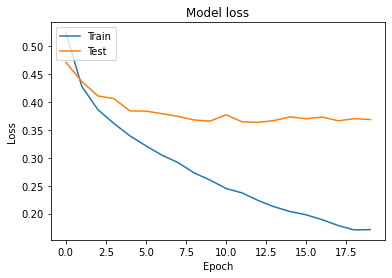

In [24]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

### Fine-Tuning

In [20]:
# Unfreeze the base model
base_model.trainable = True

# Compile the model with a low learning rate
model.compile(optimizer=keras.optimizers.Adam(learning_rate = 0.0001),
              loss = [categorical_focal_loss()] , metrics = ['categorical_accuracy'])

In [ ]:
model.fit(train_it,
          validation_data=valid_it,
          steps_per_epoch=train_it.samples/train_it.batch_size,
          validation_steps=valid_it.samples/valid_it.batch_size,
          epochs=15)

In [41]:
model.evaluate(valid_it, steps=valid_it.samples/valid_it.batch_size)

103/103 [==============================] - 27s 258ms/step - loss: 0.2781 - categorical_accuracy: 0.5877


[0.27807506918907166, 0.5876505970954895]

In [42]:
model.save('VGG16-FocalLoss-Fine')

In [ ]:
model = keras.models.load_model('VGG16-FocalLoss-Fine.h5', custom_objects={'loss': categorical_focal_loss()})

In [ ]:
model.summary()